# 任务三 —— CIFAR-10 图像分类
+ 加载数据集

In [43]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. 数据预处理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# 测试集兼验证集
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 查看数据集基本信息
print(f"数据集类型: {type(trainset)}")
print(f"数据集样本数量: {len(trainset)}") 

#查看单个数据
image, label = trainset[0]
print(image.shape, classes[label])

数据集类型: <class 'torchvision.datasets.cifar.CIFAR10'>
数据集样本数量: 50000
torch.Size([3, 32, 32]) frog


+ 构建简单的卷积神经网络（设计一个简单的卷积神经网络，输入的单个样本形状为（3，32，32）.设计参考lenet）

In [44]:
# 2. 构建你的CNN模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # --- 在这里定义前向传播逻辑 ---
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = nn.Flatten()(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = SimpleCNN().to(device)
print(net)

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


+ 定义损失函数和优化器

In [45]:
lr = 5e-4
criterion = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = optim.Adam(net.parameters(), lr = lr)

+ 定义后续计算准确度和绘图的工具（代码参考《动手学深度学习》）

In [46]:
# 以预测正确的数量作为准确度
# 输出的形状为（batch_size, num_classes)
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
#这个类挺有用的，在后面就能看见。
    
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [47]:
from IPython import display


def set_axes(ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if legend: ax.legend(legend)
    ax.grid()

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(8, 5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

#animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],legend=['train loss', 'train acc', 'test acc'])
#上面一行即为创建该类的一个实例演示

+ 搭建训练函数

In [48]:
def train(net, train_iter, test_iter, num_epochs, optimizer, criterion,device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)   #采用Xavier方法对参数进行初始化
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    loss = criterion
    animator_acc = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train acc', 'test acc'])
    animator_loss = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss'])
    num_batches = len(train_iter)
    for epoch in range(num_epochs):  #每一轮训练均会遍历数据集的所有值
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):

            # 计算模块
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            # 动态绘图模块
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1: #每训练1/5批或最后一批，进行可视化
                animator_acc.add(epoch + (i + 1) / num_batches,
                             (train_acc, None))
                animator_loss.add(epoch + (i + 1) / num_batches,
                             (train_l))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator_acc.add(epoch + 1, ( None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

+ 开始训练

loss 0.821, train acc 0.711, test acc 0.650


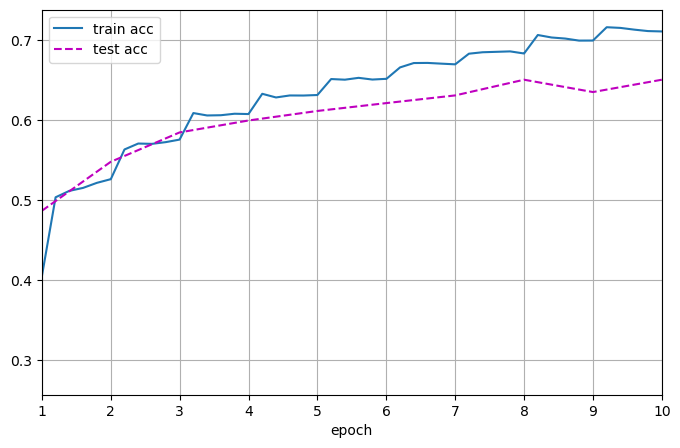

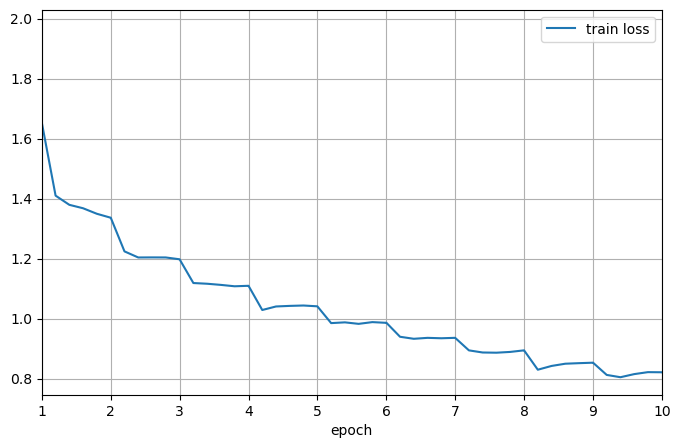

In [49]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(net, trainloader, testloader, num_epochs, optimizer, criterion, device)

+ **结果分析**：从训练的效果上看，结果比较一般。一是因为损失函数貌似还没有收敛，这和学习率和训练轮数有关；二是训练集和测试集上的accuracy都很低，说明模型表达能力还不够。另一方面，从二者的差值上。我们能看到一些过拟合的趋势，需要添加一些正则化的方法。

****
**以下是改进部分**：

+ 首先，我们先来改变我们的模型。之前的模型是仿照lenet实现的，因为lenet在处理minist数据集时表现很好，而cifar-10中的数据尺寸和minist差不多（前者是3 * 32 *32， 后者是1 * 28 * 28），所以修改起来很方便。再加上示例代码中自定义模型叫做simplenet，lenet无疑是符合这个标准的。但从上面的训练结果看，这样的模型是不够的。在改进部分，我将使用更加复杂的resnet模型。由于模型的表达能力增强了，因此我添加了dropout和batchnorm等正则化手段。

In [50]:
import torch.nn.functional as F
from torchsummary import summary
# use cmd !pip install torchsummary to install this package

# 残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

# 第一层：保持 CIFAR-10 尺寸，不做过早下采样
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU()
)

# 构建 ResNet 模块
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

# 网络结构
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)  # CIFAR-10 有 10 类
)

net = net.to(device)

# 打印网络结构
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,928
       BatchNorm2d-7           [-1, 64, 32, 32]             128
          Residual-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
         Residual-13           [-1, 64, 32, 32]               0
           Conv2d-14          [-1, 128,

+ 为减少过拟合，使用数据增强

In [54]:
import torchvision.transforms as transforms
from torch.utils.data import random_split

# 训练集数据增强
train_transform = transforms.Compose([
    #如果直接在原图上随机裁剪 32×32，几乎只能得到原图本身，随机性很小。
    transforms.RandomCrop(32, padding=4),       # 随机裁剪并填充，保持 32x32
    transforms.RandomHorizontalFlip(),          # 随机水平翻转
    transforms.ToTensor(),
    # CIFAR-10 官方常用的归一化参数
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])

# 测试集数据处理（不做随机增强）
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])

#重载数据集
# 这里将训练集划分为训练集和验证集，比例为9:1
# 与之前直接将测试集作为验证集合相比，这样做可以让训练速度加快（因为原测试集有10000张图片），而且可以使test集完全独立于训练过程
fullset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainset, valset = random_split(fullset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

+ 调整适合renset的学习率并开始训练

loss 0.220, train acc 0.924, test acc 0.869


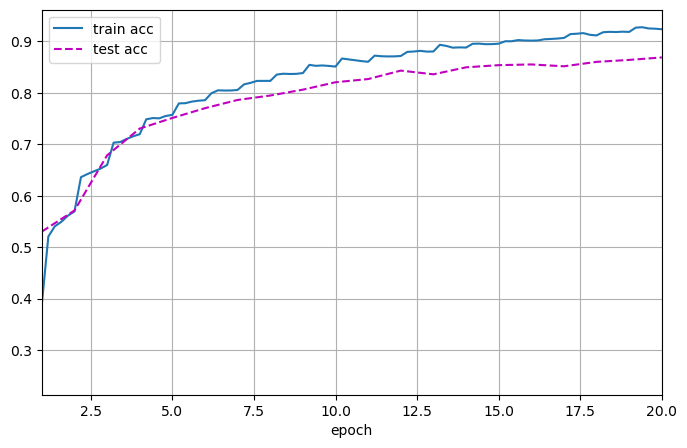

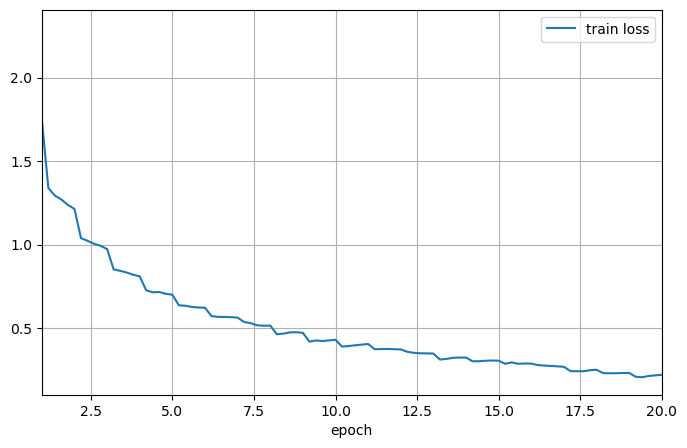

In [55]:
lr = 1e-4
criterion = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = optim.Adam(net.parameters(), lr = lr)
num_epochs = 20 #增加训练轮数，找到损失函数的收敛点
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(net, trainloader, valloader, num_epochs, optimizer, criterion, device)

+ **改进后的训练结果分析**：从改进的结果上看，训练结果较好。有一些过拟合不过好在验证集准确度较高。下面我们使用测试集进行测试，看看它的效果到底如何

***
**预测**
+ **尝试预测**：在改进时，我们将原训练集按照9：1的比例划分为了训练集和验证集，为的是可以让测试集发挥它本应该的作用，检验训练后得到的模型的泛化性。下面我们将编写用于测试的函数。

In [ ]:
#用于评估模型在测试集上的准确率

def predict_accuracy(net, test_iter):
    net.eval()
    cnt = 0
    total = 0
    with torch.no_grad():
        for i, (data, label) in enumerate(test_iter):
            data, label = data.to(device), label.to(device)
            output = net(data)
            y_hat = output.argmax(axis=1)
            cmp = y_hat.type(label.dtype) == label
            cnt += int(cmp.type(label.dtype).sum())
            total += label.size(0)
    print(f'Test Accuracy: {cnt / total:.3f} ({cnt}/{total})')

# 取n个数据进行预测
def predict_n(net, testset, n):
    net.eval()
    for i in range(n):
        img, label = testset[i]
        with torch.no_grad():
            img = img.unsqueeze(0).to(device) # 增加batch维度，以适应模型输入
            output = net(img)
            y_hat = output.argmax(axis=1).item()
        img = img * 0.5 + 0.5  # 反归一化
        # img_nomalized = (img - 0.5) / 0.5
        img = torch.clamp(img, 0, 1)  # 裁剪到合法范围
        plt.imshow(img.squeeze().permute(1, 2, 0).cpu())
        plt.title(f'Predicted: {classes[y_hat]}, Actual: {classes[label]}')
        plt.axis('off') # 关闭坐标轴显示
        plt.show()

Test Accuracy: 0.878 (8778/10000)


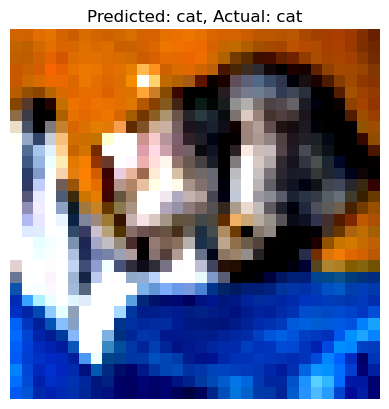

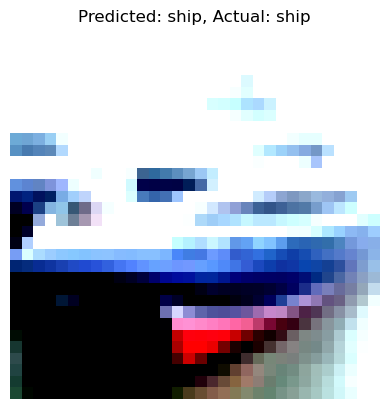

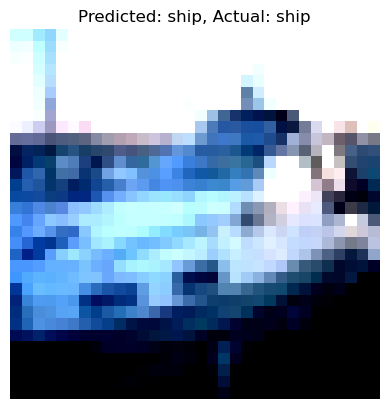

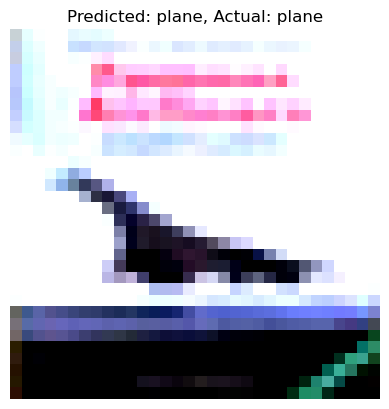

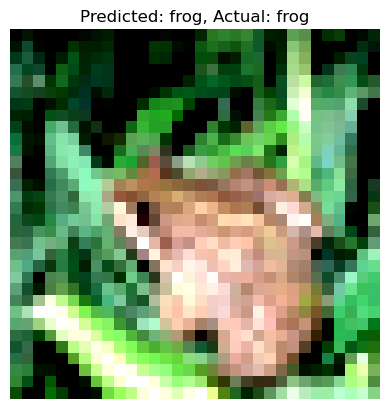

In [63]:
predict_accuracy(net, testloader)
predict_n(net, testset, 5)

+ **分析**：从预测结果来看，我们训练后的模型在测试集上的表现与验证集相当，准确度还算是比较高的。如果想进一步提高准确度，估计得采用预训练和使用ViT了。不过这不是本部分该讨论的内容

****
**写在最后**：
    在大一下的时候，我选择了ys老师的CNN图像分类PBLF课。那时在小组里我负责整个框架的搭建和初步训练，训练效果的改进等工作交给了其他成员。这一次的代码，有很大一部分来自于我的那个项目，并面对数据集做了很多改进。对比这两次项目，我觉得最大的改变就是我能清楚地知道每一步在干什么且为什么这样做了，发现问题的效率也更快了。这个任务进一步提高了我深度学习的实践能力，收获很多。